### Centro Universit√°rio Senac  
**Professor**: **Rafael C√≥be (raphaelmcobe@gmail.com)**  
**Disciplina**: Introdu√ß√£o ao Aprendizado de M√°quina  

### Projeto - **Detec√ß√£o de fraudes em transa√ß√µes de Cart√£o de Cr√©dito**

### Autores
**Renato Calabro (calabro@live.com)**
**√Ågata Oliveira (agata.aso@hotmail.com)**
**Lucas Parisi (parisi.lucas@gmail.com)**
**Douglas Carvalho Rocha (douglas.particular@gmail.com)**
**Angel Guillermo Morales Romero (aguilhermemr@gmail.com)**

### Descri√ß√£o

√â importante que as empresas de cart√£o de cr√©dito sejam capazes de reconhecer transa√ß√µes
fraudulentas com cart√£o de cr√©dito para que os clientes n√£o sejam cobrados por itens que n√£o
compraram.
Esse conjunto de dados est√° dispon√≠vel ap√≥s passar pelo algoritmo PCA. Isso garante o
anonimato.
Nesse projeto, o maior desafio ser√° lidar com classes desbalanceadas. Aqui podem ser
utilizadas uma gama de algoritmos para an√°lise de dados, al√©m de estrat√©gias para otimiza√ß√£o
de hiperpar√¢metros e combina√ß√£o de classificadores.

### Considera√ß√µes sobre PCA

- PCA (Principal Component Analysis) transforma vari√°veis originais em combina√ß√µes lineares ortogonais, maximizando a vari√¢ncia explicada.
- As componentes PCA:
  - S√£o centradas e padronizadas (m√©dia ‚âà 0).
  - Perdem interpretabilidade direta.
  - Est√£o ordenadas por import√¢ncia (V1 > V2 > ... > V28).
- Portanto, **transforma√ß√µes adicionais sobre componentes PCA (ex: log, minmax)** **n√£o s√£o recomendadas**.

In [ ]:
!../.venv/bin/python --version
%pip install -r ../requirements.txt

In [3]:
from pathlib import Path
import pandas as pd
from pathlib import Path
import joblib

from scipy.io import arff

base_path = Path("../datasets/credit-card-fraud")
models_path = Path("./models")



### Sobre os dados - CreditCardFraudDetection

Ref: https://www.openml.org/search?type=data&sort=runs&id=42175&status=active

√â importante que as empresas de cart√£o de cr√©dito consigam reconhecer transa√ß√µes fraudulentas para que os clientes n√£o sejam cobrados por itens que n√£o compraram.

#### Conte√∫do

O conjunto de dados cont√©m transa√ß√µes realizadas com cart√µes de cr√©dito em setembro de 2013 por portadores de cart√£o europeus. O dataset apresenta transa√ß√µes que ocorreram ao longo de dois dias, nas quais foram identificadas 492 fraudes entre 284.807 transa√ß√µes. O conjunto √© altamente desbalanceado: a classe positiva (fraudes) representa apenas 0,172% de todas as transa√ß√µes.

Ele cont√©m apenas vari√°veis num√©ricas como entrada, que s√£o resultado de uma transforma√ß√£o via PCA. Infelizmente, por quest√µes de confidencialidade, n√£o podemos fornecer as vari√°veis originais nem mais informa√ß√µes de contexto sobre os dados. As vari√°veis `V1`, `V2`, ..., `V28` s√£o os componentes principais obtidos via PCA; as √∫nicas vari√°veis que **n√£o** foram transformadas s√£o `Time` e `Amount`. 

- A vari√°vel `Time` representa o tempo (em segundos) decorrido desde a primeira transa√ß√£o do dataset.
- A vari√°vel `Amount` representa o valor da transa√ß√£o, podendo ser usada em estrat√©gias de aprendizado sens√≠vel a custo.
- A vari√°vel `Class` √© a vari√°vel alvo, assumindo o valor 1 em caso de fraude e 0 caso contr√°rio.

#### Inspira√ß√£o

Identificar transa√ß√µes fraudulentas com cart√£o de cr√©dito.

Dado o desequil√≠brio entre as classes, recomenda-se avaliar o desempenho usando a m√©trica **√Årea sob a Curva Precis√£o-Revoca√ß√£o (AUPRC)**. A acur√°cia da matriz de confus√£o n√£o √© significativa nesse cen√°rio de classifica√ß√£o desbalanceada.

---

In [4]:
ratings_file = base_path / "dataset.arff"

data, meta = arff.loadarff(ratings_file)

raw_data = pd.DataFrame(data)
for col in raw_data.select_dtypes([object]):
    raw_data[col] = raw_data[col].str.decode('utf-8')

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt

In [6]:
X = raw_data.drop(columns=["Class"])
y = raw_data["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

metrics = ["precision", "f1", "roc_auc", "average_precision"]

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("power", PowerTransformer(standardize=True), ["V28", "Amount"]),
    ],
    remainder="passthrough"
)

def create_pipeline(model, preprocessor=preprocessor):
    return Pipeline([
        ("preprocessing", preprocessor),
        ("clf", model)
    ])

display_labels=["0 - Leg√≠timo", "1 - Fraude"]

In [8]:
def plot_threshold_metrics(model, X, y_true, title_prefix=""):
    y_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)


    precision, recall, f1 = [], [], []
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        precision.append(precision_score(y_true, y_pred_t, zero_division=0))
        recall.append(recall_score(y_true, y_pred_t, zero_division=0))
        f1.append(f1_score(y_true, y_pred_t, zero_division=0))

    # Plot
    plt.figure(figsize=(14, 6))

    # Precision
    plt.plot(thresholds, precision, label='Precision', marker='o')
    for i, t in enumerate(thresholds):
        plt.annotate(f"{t:.2f}", (thresholds[i], precision[i]), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    # Recall
    plt.plot(thresholds, recall, label='Recall', marker='o')
    for i, t in enumerate(thresholds):
        plt.annotate(f"{t:.2f}", (thresholds[i], recall[i]), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    # F1 Score
    plt.plot(thresholds, f1, label='F1 Score', marker='o')
    for i, t in enumerate(thresholds):
        plt.annotate(f"{t:.2f}", (thresholds[i], f1[i]), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{title_prefix}Precision, Recall e F1 vs Threshold (via ROC Curve)")
    plt.legend()
    plt.grid(True)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

In [9]:
def predict_with_threshold(model, X, threshold: float = 0.5):
    y_proba = model.predict_proba(X)[:, 1]
    return (y_proba >= threshold).astype(int)

### Ajuste de Threshold e Justificativa

Para otimizar a detec√ß√£o de fraudes, foi realizada uma an√°lise visual das m√©tricas de desempenho (Precision, Recall e F1 Score) em fun√ß√£o dos thresholds de decis√£o. O objetivo foi encontrar o ponto de corte ideal para transformar as probabilidades previstas pelos modelos em classes (fraude ou leg√≠timo), com foco na redu√ß√£o dos falsos negativos.

##### Etapas do Processo:

1. **Gera√ß√£o das curvas** de Precision, Recall e F1 Score com base nos thresholds extra√≠dos da `roc_curve`, que fornece uma resolu√ß√£o mais refinada e aderente ao comportamento do classificador.
2. **An√°lise visual das curvas**, observando a regi√£o em que:
   - O F1 Score atinge seu valor m√°ximo.
   - Precision e Recall se estabilizam ou convergem.
3. **Escolha do threshold √≥timo**, priorizando o equil√≠brio entre sensibilidade (Recall) e especificidade (Precision). O ponto selecionado apresentou:
   - **Alta precis√£o**, para evitar alarmes falsos (falsos positivos).
   - **Alto recall**, essencial para garantir que a maior parte das fraudes reais seja identificada.
   - **F1 Score elevado**, indicando bom equil√≠brio entre as duas m√©tricas.

##### Justificativa:

Em contextos de **fraude financeira**, a consequ√™ncia de deixar passar uma fraude (falso negativo) √© muito mais grave do que gerar uma falsa suspeita (falso positivo). Por isso, o **threshold padr√£o (0.5)** pode n√£o ser o mais adequado, j√° que n√£o leva em conta o custo dos erros de classifica√ß√£o.

Ao utilizar a an√°lise das curvas, foi poss√≠vel **ajustar o threshold para um ponto em que o modelo √© mais sens√≠vel √† detec√ß√£o de fraudes**, sem comprometer excessivamente a precis√£o. Essa abordagem contribui para um sistema de detec√ß√£o mais robusto, alinhado com os objetivos do neg√≥cio e as exig√™ncias operacionais.



#### Random Forest

Melhores par√¢metros: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_leaf_nodes': 50}


In [10]:
rf_model_name = "fraud_pipeline_rf-gini-depth10-leaf50-powertransform-v1.joblib"
rf_model_file = models_path / rf_model_name

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(
    random_state=42, 
    n_estimators=10,
    criterion="gini",
    max_depth=10,
    max_leaf_nodes=50,
    n_jobs=-1
)

rf_pipeline = create_pipeline(rf_final, preprocessor)

display(rf_pipeline.fit(X_train, y_train))
joblib.dump(rf_pipeline, rf_model_file)

/home/rcalabro/codebase/senac-ia/machine-learning/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power', PowerTransformer(),
                                                  ['V28', 'Amount'])])),
                ('clf',
                 RandomForestClassifier(max_depth=10, max_leaf_nodes=50,
                                        n_estimators=10, n_jobs=-1,
                                        random_state=42))])

['models/fraud_pipeline_rf-gini-depth10-leaf50-powertransform-v1.joblib']

In [11]:
rf_pipeline = joblib.load(rf_model_file)

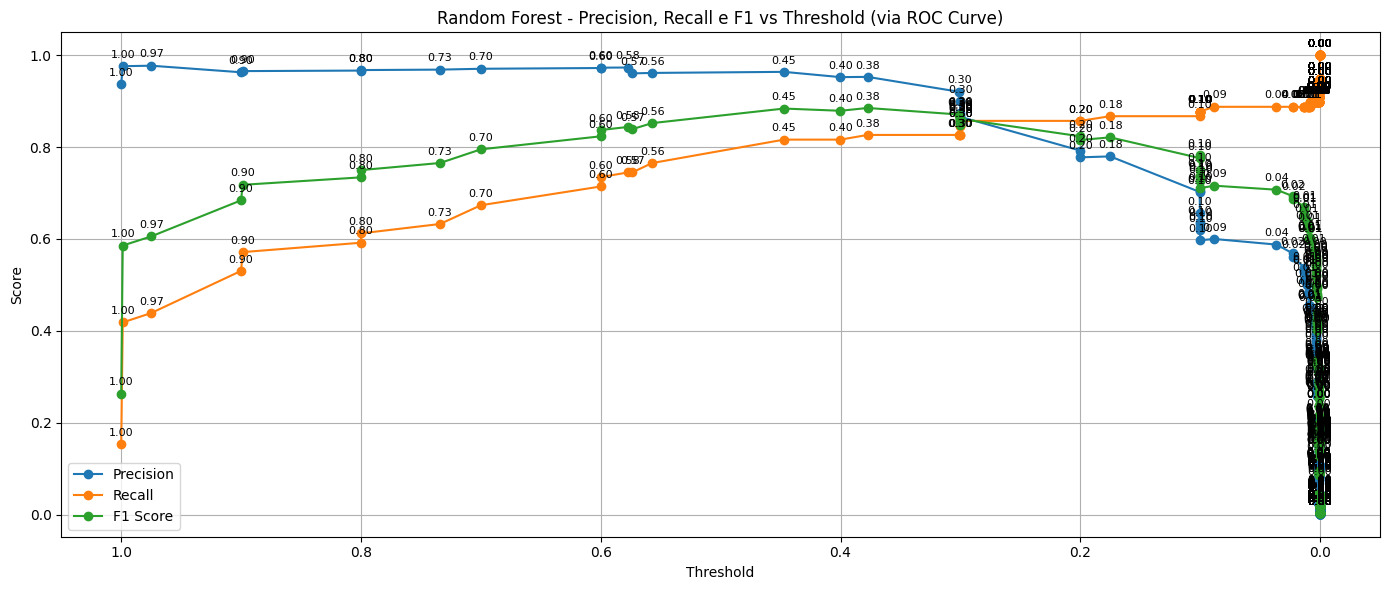

In [42]:
plot_threshold_metrics(rf_pipeline, X_test, y_test, title_prefix="Random Forest - ")

In [23]:
rf_threshold = 0.30 # an√°lise visual
rf_y_pred = predict_with_threshold(rf_pipeline, X_test, rf_threshold)
rf_y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

'PR AUC (Average Precision): 0.8520'

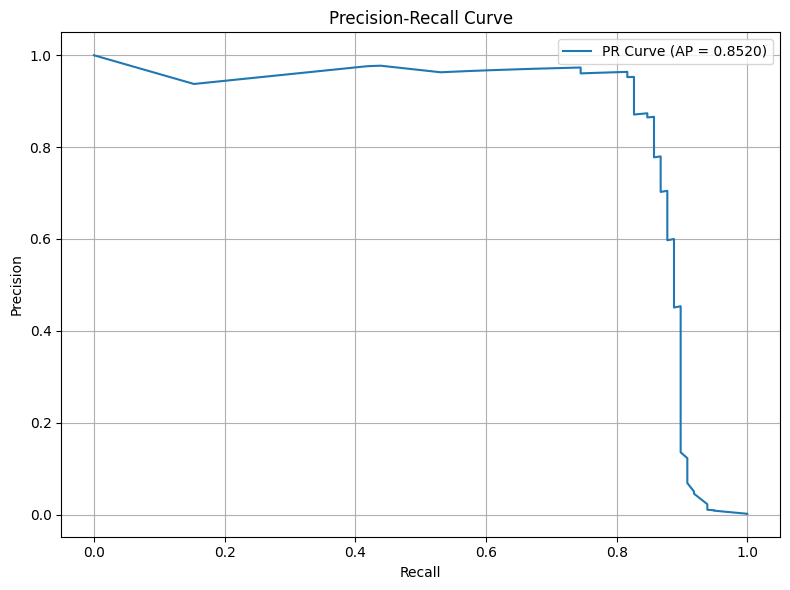

In [24]:
rf_pr_auc = average_precision_score(y_test, rf_y_proba)
display(f"PR AUC (Average Precision): {rf_pr_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, rf_y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {rf_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### RandomForest - Interpreta√ß√£o da Precision-Recall Curve

- O valor de **Average Precision (AP) √© 0.8520**, o que indica uma performance s√≥lida ‚Äî o modelo consegue manter boa precis√£o mesmo enquanto aumenta o recall.
- A curva permanece com **alta precis√£o (acima de 0.95)** at√© aproximadamente **80% de recall**, sugerindo que o modelo √© eficaz em identificar a maioria das fraudes sem gerar muitos falsos positivos.
- A partir de 80% de recall, a precis√£o come√ßa a cair acentuadamente, evidenciando o **trade-off natural** entre aumentar a cobertura (recall) e manter a qualidade das predi√ß√µes (precis√£o).

O desempenho geral √© bom, com o modelo equilibrando corretamente os dois objetivos em grande parte da curva. Isso o torna uma op√ß√£o vi√°vel para cen√°rios em que √© prefer√≠vel errar por excesso (investigar falsos positivos) a deixar passar fraudes reais.


üìä Classification Report Random Forest (valida√ß√£o):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.87      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



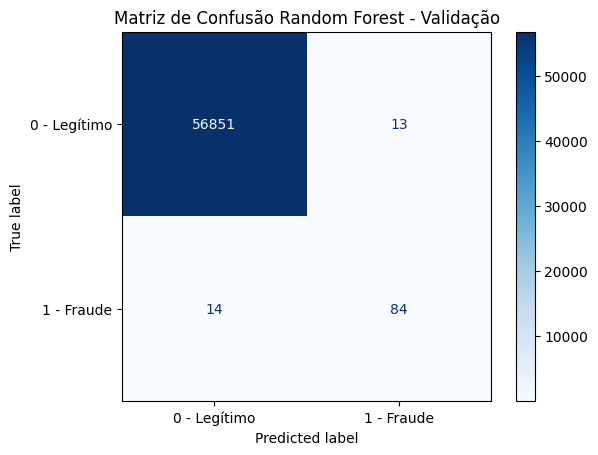

In [52]:
print("üìä Classification Report Random Forest (valida√ß√£o):")
print(classification_report(y_test, rf_y_pred))

val_cm = confusion_matrix(y_test, rf_y_pred)

val_disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=display_labels)
val_disp.plot(cmap='Blues')
plt.title("Matriz de Confus√£o Random Forest - Valida√ß√£o")
plt.show()

#### XGBClassifier

Melhores par√¢metros: {'clf__learning_rate': None, 'clf__max_depth': 10, 'clf__scale_pos_weight': 10}

In [12]:
xgb_model_name = "fraud_pipeline_xgb-depth10-wscale10-powertransform-v1.joblib"
xgb_model_file = models_path / xgb_model_name

In [54]:
from xgboost import XGBClassifier

xgb_final = XGBClassifier(
    random_state=42, 
    n_estimators=50, 
    eval_metric="logloss",
    learning_rate=None,
    max_depth=10,
    scale_pos_weight=10,
)

xgb_pipeline = create_pipeline(xgb_final, preprocessor)

display(xgb_pipeline.fit(X_train, y_train))
joblib.dump(xgb_pipeline, xgb_model_file)

/home/rcalabro/codebase/senac-ia/machine-learning/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power', PowerTransformer(),
                                                  ['V28', 'Amount'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='log...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

['models/fraud_pipeline_xgb-depth10-wscale10-powertransform-v1.joblib']

In [13]:
xgb_pipeline = joblib.load(xgb_model_file)

/tmp/ipykernel_340666/952016526.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/rcalabro/codebase/senac-ia/machine-learning/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


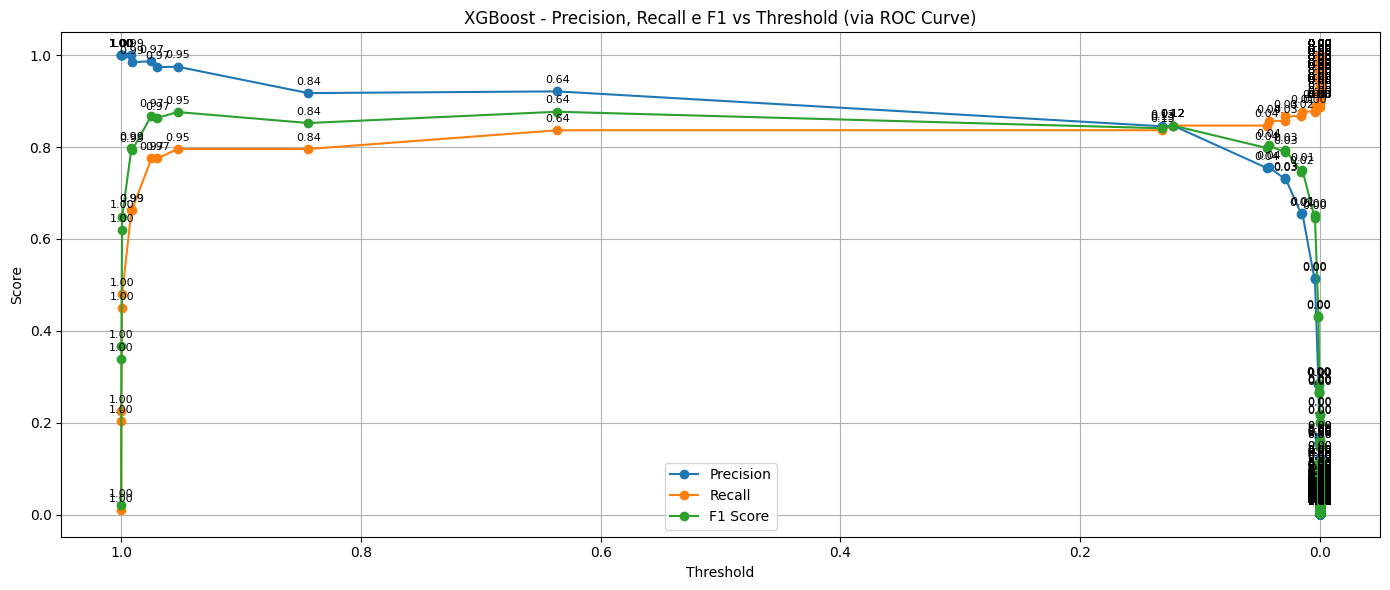

In [19]:
plot_threshold_metrics(xgb_pipeline, X_test, y_test, title_prefix="XGBoost - ")

In [15]:
xbg_threshold = 0.12 # an√°lise visual
xgb_y_pred = predict_with_threshold(xgb_pipeline, X_test, xbg_threshold)
xgb_y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

'PR AUC (Average Precision): 0.8717'

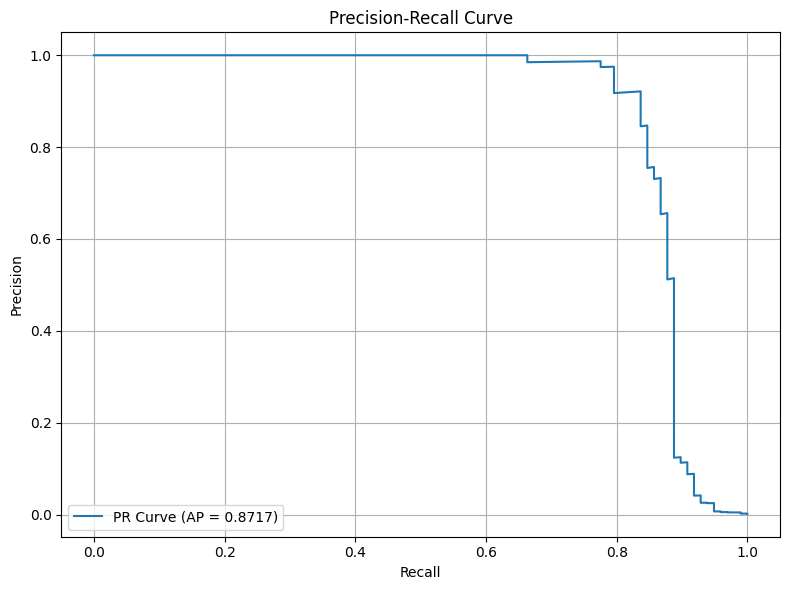

In [22]:
xgb_pr_auc = average_precision_score(y_test, xgb_y_proba)
display(f"PR AUC (Average Precision): {xgb_pr_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, xgb_y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {xgb_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### XGBClassifier - Interpreta√ß√£o da Precision-Recall Curve

- O modelo obteve um **Average Precision (AP) de 0.8717**, indicando alta capacidade de identificar transa√ß√µes fraudulentas mantendo boa precis√£o.
- A curva se mant√©m em n√≠veis altos de **precis√£o** at√© aproximadamente 80% de **recall**, o que mostra que o modelo consegue detectar a maioria das fraudes sem gerar muitos falsos positivos.
- A partir de certo ponto, a precis√£o cai rapidamente √† medida que o recall se aproxima de 1.0, evidenciando o trade-off natural entre detectar mais fraudes e manter a confiabilidade nas predi√ß√µes.

Esse resultado √© bastante positivo e sugere que o modelo √© eficaz em priorizar alertas com alta probabilidade de fraude.


üìä Classification Report XGBClassifier (valida√ß√£o):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.85      0.85      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



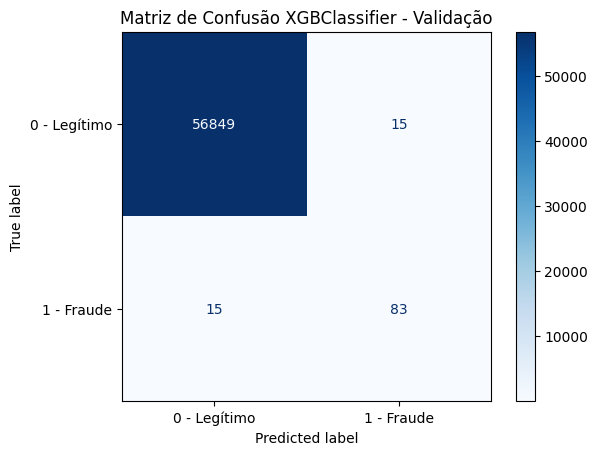

In [17]:
print("üìä Classification Report XGBClassifier (valida√ß√£o):")
print(classification_report(y_test, xgb_y_pred))

val_cm = confusion_matrix(y_test, xgb_y_pred)

val_disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=display_labels)
val_disp.plot(cmap='Blues')
plt.title("Matriz de Confus√£o XGBClassifier - Valida√ß√£o")
plt.show()


## Compara√ß√£o Final dos Modelos com Threshold Ajustado (Fraude Financeira)

Ajustar o threshold de decis√£o √© uma pr√°tica essencial em cen√°rios de fraude financeira, onde o objetivo principal √© **reduzir falsos negativos** ‚Äî ou seja, minimizar a quantidade de fraudes que s√£o classificadas como transa√ß√µes leg√≠timas. Embora esse ajuste possa impactar ligeiramente a precis√£o (mais falsos positivos), ele √© justific√°vel pelo alto custo associado a fraudes n√£o detectadas.


### Random Forest

- Falsos negativos (fraudes perdidas): 14  
- Falsos positivos (leg√≠timos marcados como fraude): 13  
- Average Precision (AP) √© 0.8520
- Melhor recall no grupo positivo.


### XGBoost

- Falsos negativos (fraudes perdidas): 15  
- Falsos positivos (leg√≠timos marcados como fraude): 15  
- Average Precision (AP) de 0.8717  
- Melhor performance geral, mas perde levemente em recall comparado ao RF.


## Conclus√£o

Ambos os modelos performam muito bem, com excelente separa√ß√£o entre classes ap√≥s ajuste do threshold. No entanto:

- Random Forest teve um recall ligeiramente melhor na classe de fraude, detectando uma fraude a mais.
- XGBoost teve melhor AUC ROC, mas com leve perda de recall.

Em contextos onde n√£o detectar fraudes custa mais do que investigar falsos positivos, como neste caso, o Random Forest com threshold ajustado √© ligeiramente mais seguro.
